## Predict whether a grant will be renewed

### Generage data with lables.
To predict whether a grant will be renewed, I first generated a table with labels by looking up the new grant from 2010, whether the grant ID is involved in later years (2011 to 2016). If the grant ID is found, then marked it as renewed (1), otherwise marked it as non-renewed (0).
By doing so, I reframe the problem as a binary classification problem.


In [92]:
import seaborn as sns
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
## import matrix for predict grant renew in 2010. 
## Selected features might be closed related to the funding renew include: Publication count; NIH insitute; total cost and grant total years.

import pandas as pd
matrix_with0 = pd.read_csv("../file/FY2010_grant_renew.csv")
matrix = matrix_with0.drop("Unnamed: 0",axis=1)
matrix.head()

,GRID,Pub_count,renewed,ADMINISTERING_IC,TOTAL_COST,GR_Total_year
0,F30NS068003,1,1,NS,32845,1
1,F31AG039247,1,1,AG,31801,1
2,F31DC010533,3,1,DC,38914,1
3,F31DC010931,3,1,DC,27229,1
4,F31DC011218,4,1,DC,27631,1


### Overview of the included features

In [94]:
## an overview of the matrix
matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4169 entries, 0 to 4168
Data columns (total 6 columns):
GRID                4169 non-null object
Pub_count           4169 non-null int64
renewed             4169 non-null int64
ADMINISTERING_IC    4169 non-null object
TOTAL_COST          4169 non-null int64
GR_Total_year       4169 non-null int64
dtypes: int64(4), object(2)
memory usage: 195.5+ KB


In [95]:
matrix.describe()

,Pub_count,renewed,TOTAL_COST,GR_Total_year
count,4169.000000,4169.000000,4.169000e+03,4169.000000
mean,3.780763,0.927081,3.620859e+05,2.028304
std,4.197831,0.260035,5.376645e+05,0.559051
min,1.000000,0.000000,1.000000e+00,1.000000
25%,1.000000,1.000000,1.584640e+05,2.000000
50%,2.000000,1.000000,2.962250e+05,2.000000
75%,5.000000,1.000000,3.934580e+05,2.000000
max,40.000000,1.000000,1.499600e+07,6.000000


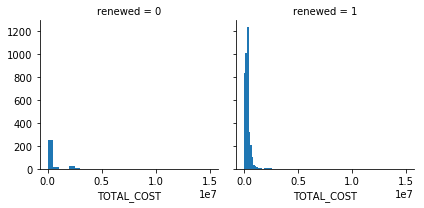

In [96]:
## plot histogram 
g = sns.FacetGrid(matrix, col='renewed')
g.map(plt.hist, 'TOTAL_COST', bins=30)

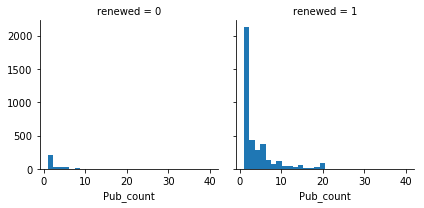

In [97]:
g1 = sns.FacetGrid(matrix, col='renewed')
g1.map(plt.hist, 'Pub_count', bins=30)

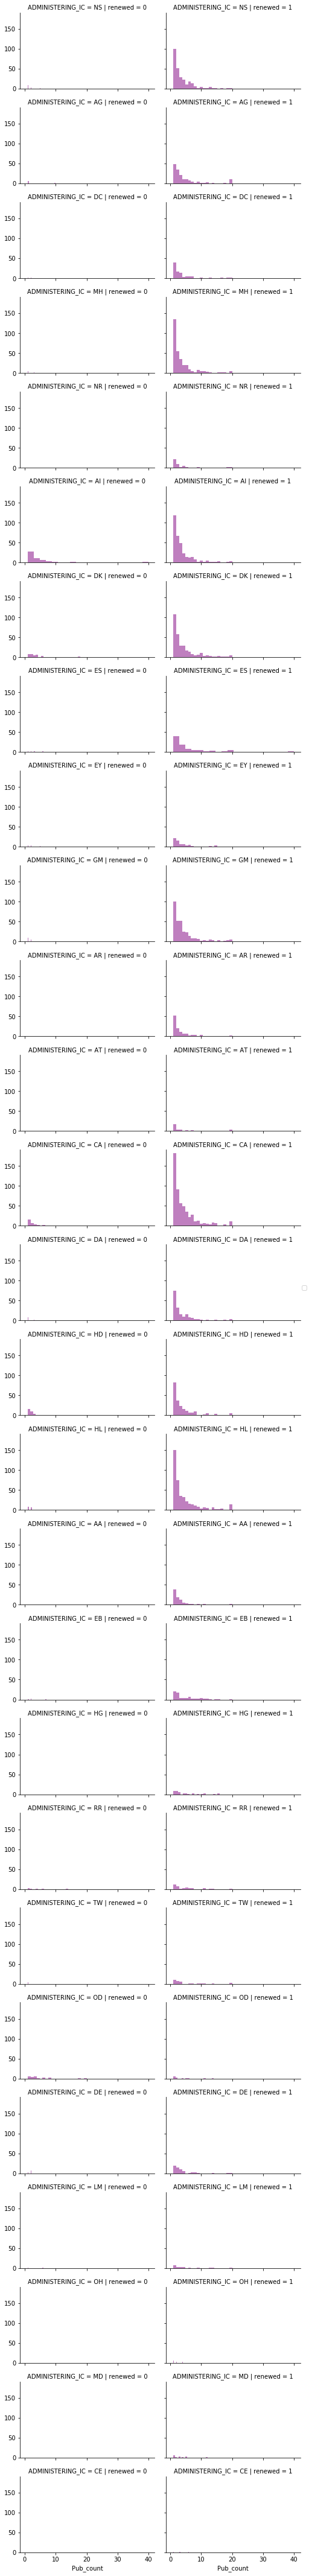

In [98]:
grid = sns.FacetGrid(matrix, col='renewed', row='ADMINISTERING_IC', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Pub_count', alpha=.5, bins=20,color="purple")
grid.add_legend()
#grid.savefig("institut_renew.png")

In [99]:
list1 = ["CA","AI","GM"]
matrix_selected = matrix.loc[matrix["ADMINISTERING_IC"].isin(list1)]
matrix_selected.head()

,GRID,Pub_count,renewed,ADMINISTERING_IC,TOTAL_COST,GR_Total_year
17,F32AI082890,1,0,AI,21685,1
21,F32GM086948,1,1,GM,47606,1
22,F32GM090405,1,0,GM,17177,1
23,F32GM090475,7,1,GM,45590,1
24,F32GM090486,2,1,GM,47606,1


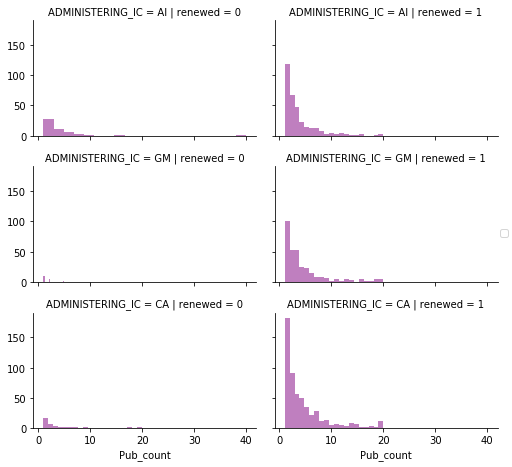

In [100]:
grid = sns.FacetGrid(matrix_selected, col='renewed', row='ADMINISTERING_IC', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Pub_count', alpha=.5, bins=20,color="purple")
grid.add_legend()
grid.savefig("grant_renew_plot1.png")

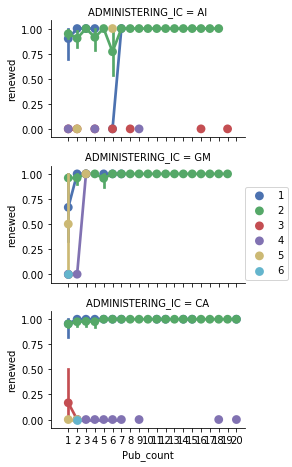

In [101]:
grid = sns.FacetGrid(matrix_selected, row='ADMINISTERING_IC', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pub_count', 'renewed', 'GR_Total_year', palette='deep',lable=["1","2","3","4","5"])
grid.add_legend()

plt.xlim(-2,20)
grid.savefig("grant_renew_plot2.png")

### Transform categorical attributes to numbers

a) Remove GRID column and lable column

In [102]:
## remove GRID from the matrix
matrix_remove_GRID = matrix.drop("GRID",axis=1)
matrix_remove_GRID.head()

,Pub_count,renewed,ADMINISTERING_IC,TOTAL_COST,GR_Total_year
0,1,1,NS,32845,1
1,1,1,AG,31801,1
2,3,1,DC,38914,1
3,3,1,DC,27229,1
4,4,1,DC,27631,1


In [103]:
# Remove lable fromt the matrix
matrix_lable = matrix_remove_GRID["renewed"]

matrix_remove_lable = matrix_remove_GRID.drop("renewed",axis=1)
matrix_remove_lable.head()

,Pub_count,ADMINISTERING_IC,TOTAL_COST,GR_Total_year
0,1,NS,32845,1
1,1,AG,31801,1
2,3,DC,38914,1
3,3,DC,27229,1
4,4,DC,27631,1


b) Split matrix to numeric only and categorical only subsets.

In [104]:
## seperate numeric and categorical columns

matrix_number = matrix_remove_lable.drop("ADMINISTERING_IC",axis=1)
matrix_cat = matrix_remove_lable["ADMINISTERING_IC"]
print(matrix_number.head())
print("--"*25)
print(matrix_cat.head())

   Pub_count  TOTAL_COST  GR_Total_year
0          1       32845              1
1          1       31801              1
2          3       38914              1
3          3       27229              1
4          4       27631              1
--------------------------------------------------
0    NS
1    AG
2    DC
3    DC
4    DC
Name: ADMINISTERING_IC, dtype: object


c) Use Pandas' factorize() method to convert this string categorical feature to an integer categorical feature, which will be easier for Machine Learning algorithms to handle:

In [105]:
matrix_cat_encoded, matrix_categories = matrix_cat.factorize()
print(matrix_cat_encoded[:10])
print("--"*35)
print(matrix_categories[:10])

[0 1 2 2 2 3 3 3 3 4]
----------------------------------------------------------------------
Index(['NS', 'AG', 'DC', 'MH', 'NR', 'AI', 'DK', 'ES', 'EY', 'GM'], dtype='object')


d) One issue with above representation is that ML algorithms will assume that two
nearby values are more silimar, which is not the case obviously. To fix this issue, a common solution is to create one binary attribute per category. 
This is one-hot encoding. Next, we convert each categorical value to a one-hot vector using a OneHotEncoder:

In [106]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
matrix_cat_1hot = encoder.fit_transform(matrix_cat_encoded.reshape(-1,1))
matrix_cat_1hot

<4169x27 sparse matrix of type '<class 'numpy.float64'>'
	with 4169 stored elements in Compressed Sparse Row format>

In [107]:
## visualizat Scipy sparse matrix output by OneHotEncoder
matrix_cat_1hot.toarray()

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

e) Let us do this by using a CategoricalEncoder class, copied from PR #9151.

In [108]:
# Definition of the CategoricalEncoder class, copied from PR #9151.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [109]:
cat_encoder = CategoricalEncoder()
matrix_cat_reshaped = matrix_cat.values.reshape(-1, 1)
matrix_cat_1hot = cat_encoder.fit_transform(matrix_cat_reshaped)
matrix_cat_1hot

<4169x27 sparse matrix of type '<class 'numpy.float64'>'
	with 4169 stored elements in Compressed Sparse Row format>

In [110]:
print(matrix_cat_1hot.shape)
matrix_cat_1hot.toarray()

(4169, 27)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

This is exactly the same as using OneHotEncoder previously 

### Feature scaling of numeric features and build transformation piplines.
It is important to perform feature scaling. With few exceptions, ML don't perform well when the input numerical attributes have very different scales.

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

matrix_num_tr = num_pipeline.fit_transform(matrix_number)
matrix_num_tr

array([[-0.66250786, -0.61242725, -1.83959398],
       [-0.66250786, -0.61436921, -1.83959398],
       [-0.18601424, -0.60113819, -1.83959398],
       ..., 
       [ 1.0052198 ,  3.73495944,  7.10520108],
       [-0.42426105,  0.13562895,  7.10520108],
       [-0.66250786,  0.11683989,  7.10520108]])

### Build transformation piplines to automate the process

In [112]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [113]:
num_attribs = list(matrix_number)
cat_attribs = ["ADMINISTERING_IC"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

renew_prepared = full_pipeline.fit_transform(matrix_remove_lable)
print(matrix_remove_GRID.shape)
print(renew_prepared.shape)

(4169, 5)
(4169, 30)


/Users/yier.jin/miniconda3/envs/bio-py/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [114]:
renew_prepared

array([[-0.66250786, -0.61242725, -1.83959398, ...,  0.        ,
         0.        ,  0.        ],
       [-0.66250786, -0.61436921, -1.83959398, ...,  0.        ,
         0.        ,  0.        ],
       [-0.18601424, -0.60113819, -1.83959398, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 1.0052198 ,  3.73495944,  7.10520108, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42426105,  0.13562895,  7.10520108, ...,  0.        ,
         0.        ,  0.        ],
       [-0.66250786,  0.11683989,  7.10520108, ...,  0.        ,
         0.        ,  0.        ]])

### Test/Train data sets split

In [115]:
# to make output identical at every run
np.random.seed(42)

In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(renew_prepared, matrix_lable, test_size=0.2)

In [117]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3335, 30)
(834, 30)
(3335,)
(834,)


### Training a Stochastic Gradient Descent (SGD) classifier

In [118]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, n_iter=None)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

### Performence measure of classifer using cross-validation.

#### Measuring accuracy using cross-validation

In [119]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=10, scoring="accuracy")

array([ 0.9761194 ,  0.92814371,  0.93113772,  0.92814371,  0.96696697,
        0.95195195,  0.95195195,  0.95195195,  0.97297297,  0.90990991])

#### Evaluate model using confusion matrix

In [120]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=10)

In [121]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[ 128,  113],
       [  69, 3025]])

#### Precision and recall based on confusion matrix

In [122]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))

0.963989802422
0.977698771816


In [123]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.97079589216944806

#### Plot a ROC curve

In [136]:
from sklearn.metrics import roc_curve
y_score = cross_val_predict(sgd_clf, X_train, y_train, cv=10,
                                    method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train, y_score[:,1])

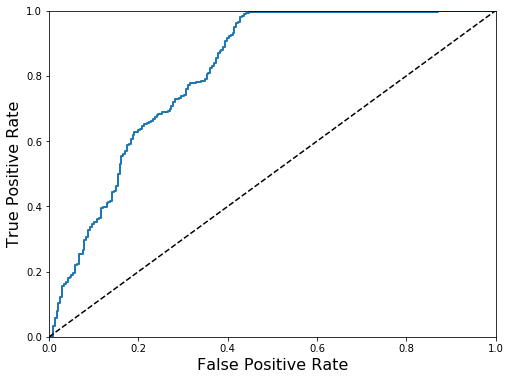

In [137]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [138]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_score[:,1])

0.81307550150606045

#### Train a random forest classifier

In [142]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_train_reshape = y_train.values.reshape(-1, 1)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=5,
                                    method="predict_proba")

In [143]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_reshape,y_scores_forest)

In [144]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_reshape, y_scores_forest)

0.83322492737918663

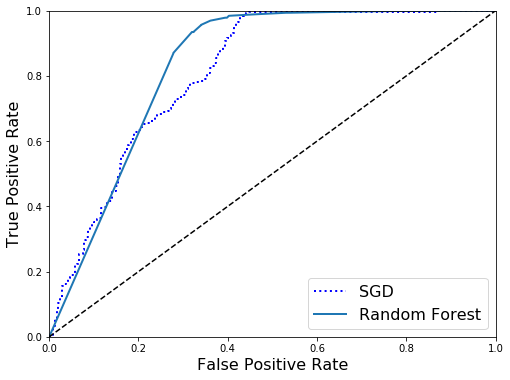

In [145]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.savefig("ROC_multiple.png")
plt.show()

### Fine tune model using grid search

In [146]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_log_loss')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [147]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 30}

In [148]:
best_model = grid_search.best_estimator_
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [149]:
y_probas_best = cross_val_predict(best_model, X_train, y_train, cv=5,
                                    method="predict_proba")

In [150]:
y_scores_best = y_probas_best[:, 1] # score = proba of positive class
fpr_fores_best, tpr_forest_best, thresholds_forest = roc_curve(y_train_reshape,y_scores_best)

In [151]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_reshape, y_scores_best)

0.85397181534599165

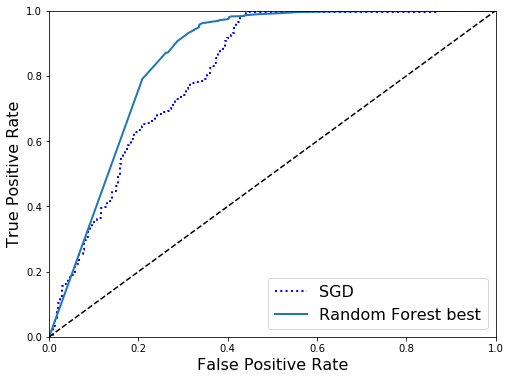

In [152]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_fores_best, tpr_forest_best, "Random Forest best")
plt.legend(loc="lower right", fontsize=16)
plt.savefig("ROC_multiple.png")
plt.show()

#### Feature importance 

In [153]:
best_model.feature_importances_

array([  7.02519548e-02,   4.08265665e-01,   4.46802227e-01,
         1.52936609e-03,   1.88082261e-03,   5.00215901e-03,
         1.31006883e-03,   9.39068553e-04,   3.31679481e-03,
         3.93103019e-05,   1.92473690e-03,   1.49854994e-03,
         2.86403910e-03,   3.68916081e-03,   1.56716714e-03,
         1.67686018e-03,   6.29673576e-04,   4.34650841e-03,
         2.99166075e-03,   5.19810383e-04,   4.66364853e-03,
         1.44020254e-03,   9.62906268e-05,   3.16401008e-03,
         2.25291696e-03,   4.42372046e-03,   2.02873164e-02,
         1.12771003e-04,   1.44557055e-03,   1.06794896e-03])

In [154]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(5,6)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

3.93103019495e-05 0.446802226735


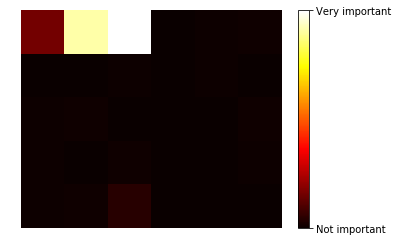

In [155]:
plot_digit(best_model.feature_importances_)

import math

trick_min = best_model.feature_importances_.min()
trick_max = best_model.feature_importances_.max()
print(trick_min,trick_max)

cbar = plt.colorbar(ticks=[trick_min, trick_max])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

#### Estimate the best model on the test data set and plot ROC curve

In [156]:
y_test_pred = best_model.predict(X_test)

In [157]:
y_probas_test = cross_val_predict(best_model, X_test, y_test, cv=5,
                                    method="predict_proba")

In [158]:
y_scores_test = y_probas_test[:, 1] # score = proba of positive class
fpr_forest_test, tpr_forest_test, thresholds_forest = roc_curve(y_test,y_scores_test)

In [161]:
roc_auc_score(y_test, y_scores_test)

0.84945340003705749

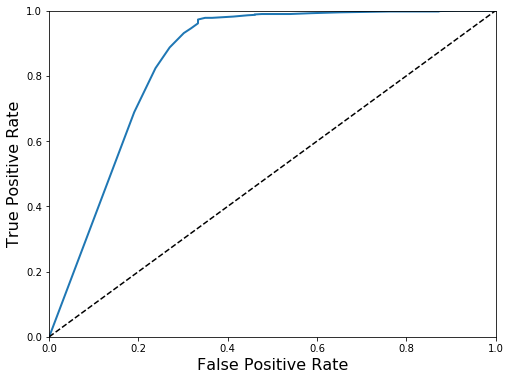

In [162]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest_test, tpr_forest_test)
plt.savefig("ROC_test.png")
plt.show()

In [163]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
print(confusion_matrix(y_test, y_test_pred))
print(precision_score(y_train, y_train_pred))
print(recall_score(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))

[[ 35  28]
 [ 18 753]]
0.963989802422
0.977698771816
0.970795892169


### Run test data set using SGD

In [191]:
y_test_pred_sgd = cross_val_predict(sgd_clf, X_test, y_test, cv=10)

In [192]:
y_test_score_sgd = cross_val_predict(sgd_clf, X_test, y_test, cv=10,
                                    method="decision_function")

fpr_sgd_test, tpr_sgd_test, thresholds_sgd_test = roc_curve(y_test, y_test_score_sgd[:,1])


In [193]:
roc_auc_score(y_test, y_test_score_sgd[:,1])

0.75926955304387223

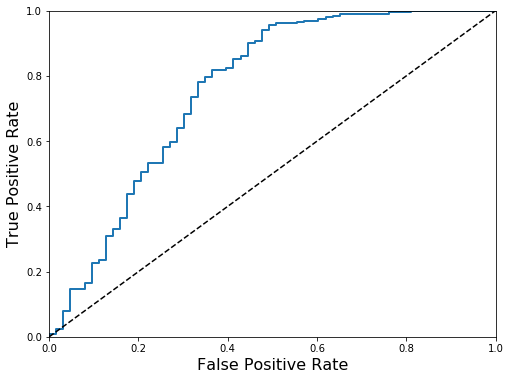

In [194]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_sgd_test, tpr_sgd_test)
plt.show()